In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

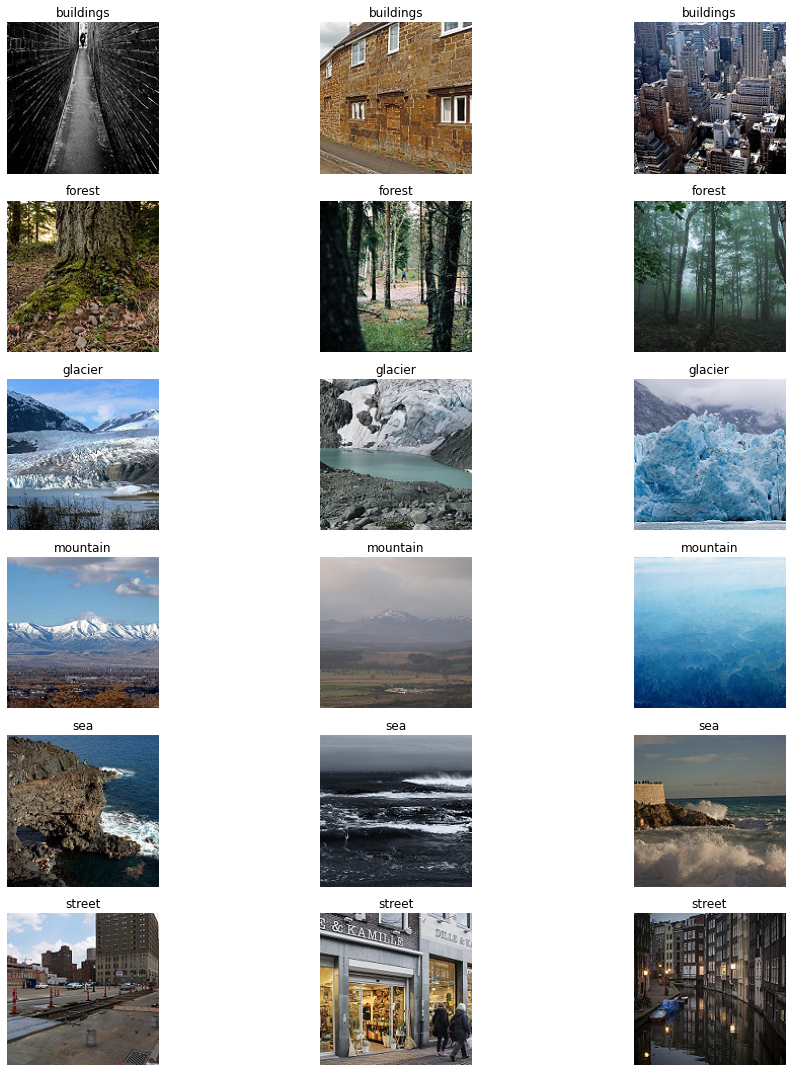

In [3]:
# Path to the directory containing the images
base_directory = 'C:/Users/Maya/OneDrive/Desktop/Intel_Images/seg_train/seg_train/'

# Categories
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Display three random images for each category
fig, axs = plt.subplots(len(categories), 3, figsize=(15, 15))

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    random_images = random.sample(image_files, 3)
    
    for j, image_file in enumerate(random_images):
        image_path = os.path.join(category_directory, image_file)
        image = mpimg.imread(image_path)
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(category)

plt.tight_layout()
plt.show()


In [8]:
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
category_dict = {category: i for i, category in enumerate(categories)}

def load_data():
    datasets = ['C:/Users/Maya/OneDrive/Desktop/Intel_Images/seg_train/seg_train', 
                'C:/Users/Maya/OneDrive/Desktop/Intel_Images/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = category_dict[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = Image.open(img_path)
                image = image.resize((150, 150))
                
                # Append the image and its corresponding label to the output
                images.append(np.array(image))
                labels.append(label)
                
        images = np.stack(images, axis=0)
        labels = np.array(labels, dtype='int32')
   
        output.append((images, labels))

    return output


In [9]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  4%|▍         | 86/2191 [00:00<00:02, 851.89it/s]

Loading C:/Users/Maya/OneDrive/Desktop/Intel_Images/seg_train/seg_train


 17%|█▋        | 76/437 [00:00<00:00, 759.08it/s]

Loading C:/Users/Maya/OneDrive/Desktop/Intel_Images/seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 904.75it/s]


In [10]:
print("Train Images shape: ", train_images.shape)
print("Train Labels shape: ", train_labels.shape)
print("Test Images shape: ", test_images.shape)
print("Test Labels shape: ", test_labels.shape)

Train Images shape:  (14034, 150, 150, 3)
Train Labels shape:  (14034,)
Test Images shape:  (3000, 150, 150, 3)
Test Labels shape:  (3000,)


In [12]:
# Flatten out our data so we can create a db out of it
train_images_reshaped = train_images.reshape(train_images.shape[0], -1)
train_images_df = pd.DataFrame(train_images_reshaped)
train_images_df

,0,1,2,3,4,5,6,7,8,9,...,67490,67491,67492,67493,67494,67495,67496,67497,67498,67499
0,247,247,245,247,247,245,248,248,246,248,...,38,31,26,23,51,46,43,63,58,55
1,68,121,187,69,123,187,71,121,184,70,...,0,30,17,0,73,57,41,74,58,42
2,131,194,247,131,194,245,131,194,245,131,...,56,133,154,61,125,149,53,129,153,57
3,213,186,201,183,158,180,188,159,189,187,...,230,243,225,241,238,220,236,246,228,244
4,0,32,65,0,33,63,0,34,64,0,...,173,219,222,203,203,206,189,228,228,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14029,251,251,251,251,251,251,253,253,253,250,...,67,95,95,95,75,75,75,85,85,85
14030,94,97,86,89,80,73,98,80,76,101,...,92,137,110,91,136,109,90,136,109,90
14031,63,61,66,117,114,123,103,100,111,62,...,131,152,153,148,131,132,127,141,142,137
14032,0,28,98,0,29,103,0,29,103,0,...,3,8,3,7,4,0,3,3,0,2


In [15]:
train_labels_df = pd.DataFrame(train_labels, columns = ['labels'])
train_df = pd.concat([train_images_df, train_labels_df], axis=1)
train_df

,0,1,2,3,4,5,6,7,8,9,...,67491,67492,67493,67494,67495,67496,67497,67498,67499,labels
0,247,247,245,247,247,245,248,248,246,248,...,31,26,23,51,46,43,63,58,55,0
1,68,121,187,69,123,187,71,121,184,70,...,30,17,0,73,57,41,74,58,42,0
2,131,194,247,131,194,245,131,194,245,131,...,133,154,61,125,149,53,129,153,57,0
3,213,186,201,183,158,180,188,159,189,187,...,243,225,241,238,220,236,246,228,244,0
4,0,32,65,0,33,63,0,34,64,0,...,219,222,203,203,206,189,228,228,216,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14029,251,251,251,251,251,251,253,253,253,250,...,95,95,95,75,75,75,85,85,85,5
14030,94,97,86,89,80,73,98,80,76,101,...,137,110,91,136,109,90,136,109,90,5
14031,63,61,66,117,114,123,103,100,111,62,...,152,153,148,131,132,127,141,142,137,5
14032,0,28,98,0,29,103,0,29,103,0,...,8,3,7,4,0,3,3,0,2,5


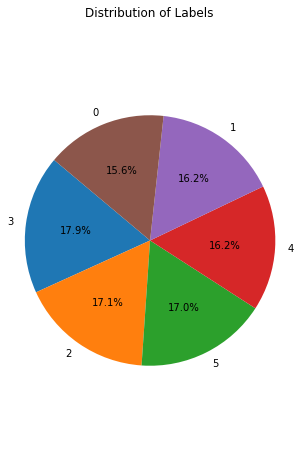

In [17]:
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = train_df['labels'].value_counts()

# Plot the pie chart
plt.figure(figsize=(5, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Labels')
plt.show()

In [26]:

# Create a permutation of indices
np.random.seed(42)
shuffle_index = np.random.permutation(len(train_images))

# Use the permutation to shuffle the images and labels
train_images = train_images[shuffle_index]
train_labels = train_labels[shuffle_index]

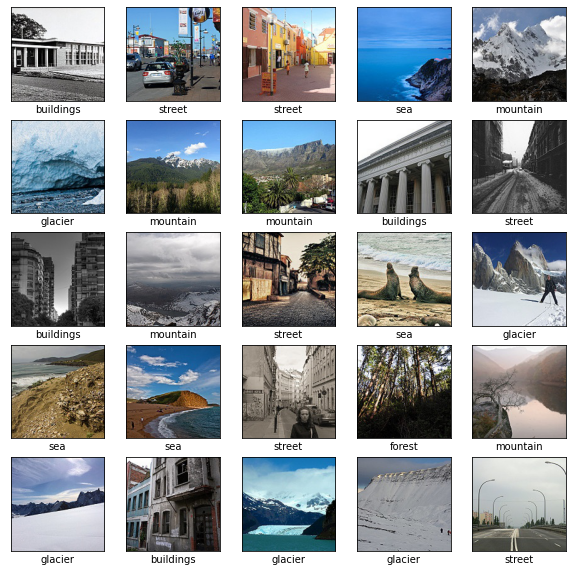

In [27]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(150, 150,3), cmap="binary")
    plt.xlabel(categories[train_labels[i]])
plt.show()